Importing the required packages 

In [5]:
import numpy as np 
import random 
import gzip
from collections import defaultdict
import matplotlib.pyplot as plt
import copy
import sys
import string
from sklearn import svm

Method to read in the data from the zipped data. Returns an iterator.

In [61]:
def readGz(f):
    for l in gzip.open(f):
        yield eval(l)

## EXPLORATORY ANALYSIS

Below is the first record in the data

In [62]:
next(readGz("train.json.gz"))

{'reviewTime': '09 26, 2013',
 'reviewText': "The model in this picture has them rolled up at the top because they are actually very high waisted! that's my only complaint though, because they are very good quality, and fit really well! I am 5'2&#34; 120lbs with thick thighs and i love them i can't wait to wear them out!",
 'helpful': {'nHelpful': 0, 'outOf': 0},
 'reviewerID': 'U490934656',
 'reviewHash': 'R798569390',
 'categories': [['Clothing, Shoes & Jewelry', 'Women'],
  ['Clothing, Shoes & Jewelry',
   'Novelty, Costumes & More',
   'Novelty',
   'Clothing',
   'Women',
   'Leggings']],
 'unixReviewTime': 1380153600,
 'itemID': 'I402344648',
 'rating': 4.0,
 'summary': 'High Waisted',
 'categoryID': 0}

Below is a legend of the data fields that appear:
- __reviewTime__: the time in mm/dd/yyyy format of when the review was made.
- __reviewText__: the text of the review in a string format.
- __helpful__: the number of people that upvoted the review as helpful.
- __reviewerID__: a unique string that represents the reviewer
- __reviewHash__: a hash number to anonymise the review
- __categories__: the different categories the item falls under 
- __unixReviewTime__: seconds passed since Jan 1, 1970 (UTC)
- __itemID__: a unique string that represents the item
- __rating__: an integer rating the reviewer gave the item
- __summary__: a short summary string of the item being reviewed
- __categoryID__: 0 = Women, 1 = Men, 2 = Girl, 3 = Boy, 4 = Infant
- __price__: the price of the item (not available for all items)

Reading in the data and counting the number of items in each category

In [63]:
datum = []
item_counts = {'0':0, '1':0, '2':0,'3':0,'4':0}
for l in readGz("train.json.gz"):
        datum.append([l['reviewText'], l['categoryID'], l['reviewerID']])
        item_counts[str(l['categoryID'])] += 1

<BarContainer object of 5 artists>

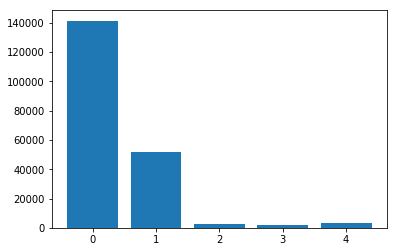

In [60]:
plt.bar(np.arange(0,5),list(item_counts.values()))

In [64]:
item_counts

{'0': 141398, '1': 51416, '2': 2329, '3': 1881, '4': 2976}

In the object above we can see that womens clothing was the most common with 141398 putchases, followed by mens, then infants, girls and boys

We will split the 200,000 data points into a training and test set, allocating 175,000 points in the training set and the remaining 25,000 points in the validation set.

In [66]:
datum_train = datum[:175000]
datum_valid = datum[175000:]

## BASELINE 

We will now create a very basic baseline where we predict the category of the item based on certain keywords appearing in the review. <br>
If the 'wife' occurs in the review, we will predict the category to be womens, 'husband' for men, 'daughter' for girls, 'son' for boys and 'baby' for infants. <br> <br>
Incase none of the words occur we will predict the category to be womens as it was the most common category.

In [69]:
### Category prediction baseline: Just consider some of the most common words from each category

catDict = {
  "Women": 0,
  "Men": 1,
  "Girls": 2,
  "Boys": 3,
  "Baby": 4
}

num = 0
den = 0

for l in datum_train:
    # If there's no evidence, just choose the most common category in the dataset
    cat = catDict['Women'] 
    words = l[0].lower()
    if 'wife' in words:
        cat = catDict['Women']
    if 'husband' in words:
        cat = catDict['Men']
    if 'daughter' in words:
        cat = catDict['Girls']
    if 'son' in words:
        cat = catDict['Boys']
    if 'baby' in words:
        cat = catDict['Baby']
    if cat == l[1]:
        num += 1
    den += 1

print(num/den)

0.6727142857142857


The accuracy of our basic baseline was __67.27%__

## PREDICTIVE MODEL

We will now create a user dictionary, which for each userID contains the itemID, categoryID and rating of every item they have purchased. <br><br>
Similarly we will have an item dictionary, which for each itemID contains userID, categoryID, rating and proportion of useful upvotes for all purchases of the item.

In [31]:
user_cat_d = {}
item_cat_d = {}
counter = 0
p = 0
for l in readGz("train.json.gz"):
    if counter < 175000:
        cat_ID = l['categoryID']
        item = l['itemID']
        user = l['reviewerID']
        helpful = l['helpful']
        
        if helpful['outOf'] == 0:
            helpful = 0
        else:
            helpful = helpful['nHelpful'] / helpful['outOf']
        
        price = 0 
        if 'price' in l.keys():
            price = l['price']
        rating = l['rating']
        
        
        tup = (user,cat_ID, rating, helpful)
        if item not in item_cat_d.keys():
            item_cat_d[item] = set([tup])
        else:
            item_cat_d[item].add(tup)

        tup = (item, cat_ID, rating)
        if user not in user_cat_d.keys():
            
            user_cat_d[user] = set([tup])
        else:
            user_cat_d[user].add(tup)
        counter += 1
    else:break

Method that scrapes through all the reviews and returns the 1000 most common words with their counts

In [72]:
### Ignore capitalization and remove punctuation
def scrape_text(dat):
    common = ['i','these','the','im','am','has','this','they'\
              ,'in','my','are','on','that', 'and', 'a', 'to','it'\
              , 'is', 'for', 'of', 'but', 'have', 'not', 'them', 'with'\
              , 'so', 'very', 'was', 'as', 'you', 'like', 'size', 'wear'\
              , 'fit', 'be', 'great', 'just', 'would', 'comfortable'\
              , 'its', 'love', 'good', 'or', 'too', 'well', 'will'\
              , 'me', 'if', 'one', 'more', 'all', 'at']
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)
    for d in dat:
        #removing the punctuation and converting the review to a lowercase
        r = ''.join([c for c in d[0].lower() if not c in punctuation])
        #looping through the words in the review and incrementing the counts in the dictionary
        for w in r.split():
            wordCount[w] += 1

    ### Just take the 1000 most popular words that are not in the common list
    counts = [(wordCount[w], w) for w in wordCount if w not in common]
    counts.sort()
    counts.reverse()

    words = [x[1] for x in counts[:1000]]
    return counts

In [73]:
#gets total frequency of top words 
tot_freq = 0 
counts = scrape_text(datum_train)
for wc in counts:
    tot_freq += (wc[0])

Gets the proportion of the counts for each word to the total counts of the top 1000 words.

In [13]:
init_500 = {}
counts = scrape_text(datum_train)
for wc in counts:
    tup_one = wc[0] /tot_freq
    tup_two = wc[1]
    init_500[tup_two] = tup_one

Segregates the training data by the category of the item

In [14]:
zero_train = []
one_train = []
two_train = []
three_train = []
four_train = []

for d in datum_train:
    cat = d[1]
    if cat == 0:
        zero_train.append(d)
    if cat == 1:
        one_train.append(d)
    if cat == 2:
        two_train.append(d)
    if cat == 3:
        three_train.append(d)
    if cat == 4:
        four_train.append(d)
        

Method to get the 1000 most common words unique to passed in dataset (each category)

In [15]:
def freq_words(ds):
    tot_freq = 0 
    counts = scrape_text(datum_train)
    new_counts = scrape_text(ds)
    
    #get the total frequency 
    for w in new_counts:
        tot_freq += w[0]

    freq_500 = {}
    
    #getting frequency of each word 
    for w in new_counts:
        tup_one = w[0] /tot_freq
        tup_two = w[1]
        freq_500[tup_two] = tup_one
    #difference in category frequency and overall frequency
    diff = {}
    for k,v in freq_500.items():
        diff[k] = v - init_500[k]
    out = sorted(diff.items(), key=lambda kv: kv[1],reverse=True)
    return out[:1000]


In [23]:
zero = freq_words(zero_train)
zero[:10]

[('bra', 0.001201640472737095),
 ('cute', 0.0007686408715002211),
 ('color', 0.0006266528756497802),
 ('dress', 0.000584970001109224),
 ('ordered', 0.000583195847440582),
 ('top', 0.0005704006338863449),
 ('small', 0.0005433016202854718),
 ('she', 0.0004898522538998007),
 ('because', 0.0004313221595723688),
 ('pretty', 0.0004193539199773945)]

In [24]:
one = freq_words(one_train)
one[:10]

[('he', 0.004512844557778415),
 ('watch', 0.0033107358975127147),
 ('husband', 0.001974343116844607),
 ('his', 0.0014634362575765068),
 ('shirt', 0.001182299492066258),
 ('socks', 0.0011130854269565654),
 ('quality', 0.0010915085376884477),
 ('him', 0.0010431960450964842),
 ('belt', 0.0009705850453025548),
 ('shirts', 0.0008652482168458952)]

In [25]:
two = freq_words(two_train)
two[:10]

[('she', 0.014442020834169402),
 ('her', 0.011677302863676242),
 ('daughter', 0.010927257186337063),
 ('old', 0.00586085881507134),
 ('year', 0.005118303693985239),
 ('loves', 0.004261394188629629),
 ('we', 0.0038995632729768824),
 ('cute', 0.003873264991969896),
 ('little', 0.0028266683090219765),
 ('dress', 0.0023693734782766706)]

In [26]:
three = freq_words(three_train)
three[:10]

[('he', 0.015178964748182415),
 ('son', 0.0130553147303708),
 ('old', 0.007989844602986598),
 ('his', 0.006959016143503843),
 ('him', 0.006725615744352958),
 ('we', 0.006210344352673987),
 ('year', 0.006054674983862761),
 ('loves', 0.004791794803135574),
 ('costume', 0.0036515058157827905),
 ('boys', 0.0035508350847411247)]

In [27]:
four = freq_words(four_train)
four[:10]

[('baby', 0.010781157840757054),
 ('her', 0.00774772770027755),
 ('cute', 0.006866010385753352),
 ('old', 0.006630260376600929),
 ('month', 0.005837247980458117),
 ('we', 0.005729618281405594),
 ('months', 0.005224189285835309),
 ('little', 0.00517018781335463),
 ('she', 0.004916463356276282),
 ('soft', 0.00456601973859075)]

From the lists above we can see that the lists of each category seems to give us a fair indication of the category. <br> <br>
We will now create a word set that contains the words from each of the four categories, we should expect the length of the list to be 5000.

In [28]:
final_word_set = zero + one + two + three + four

In [74]:
len(final_word_set)

5000

We will now create a method to extract the x and y features for the data set. The y set will contain just the category of the item, while the x will have a 5005 features. The first 5000 features represent if the words in the mega word set are present in the review or not. While the next 5 features represent the number of items in each category that the user has bought.

In [29]:
def get_xy(ds, cat):
    x_final= []
    y_final =[]

    for z in ds: 
        #append the category of the datapoint as our y value
        y_final.append(z[1])
        x = []
        #I then check if each of the 5000 words are in the review\
        #appending 1 if yes and 0 if no, as the X feature
        for wcc in final_word_set:
            k = wcc[0]
            if k in z[0]:
                x.append(1)
            else:
                x.append(0)
        ze=0
        on=0
        tw=0
        th = 0
        fo= 0
        #getting the number of items in each category that user has bought
        if z[2] in user_cat_d.keys():
            for i in list(user_cat_d[z[2]]):
                if i[1] == 0:
                    ze+=1
                if i[1] == 1:
                    on+=1
                if i[1] == 2:
                    tw+=1
                if i[1] == 3:
                    th+= 1
                if i[1] == 4:
                    fo+= 1
        x.append(ze)
        x.append(on)
        x.append(tw)
        x.append(th)
        x.append(fo)
            
        x_final.append(x)
    return x_final, y_final

We then create a copy of the training and validation sets and shuffle the data to obtain more accurate results

In [32]:
dat = copy.deepcopy(datum_train)
np.random.shuffle(dat)
dat = dat[:int(len(dat)*1)]

val = copy.deepcopy(datum_valid)
np.random.shuffle(val)
val = val[:int(len(dat)*1)]

X_train, Y_train = get_xy(dat,0)
X_val, Y_val = get_xy(val,0)

We run a LinearSVC on our data to predict the categories of items using our features. 

In [80]:
C = [0.01,0.1,1,10]
scores = {}
for c in C:
    clf = svm.LinearSVC(C=c, multi_class = 'ovr', dual = False)
    clf.fit(X_train, Y_train)
    scores[c] = clf.score(X_val, Y_val)
    print(scores)

{0.01: 0.8754}
{0.01: 0.8754, 0.1: 0.87684}
{0.01: 0.8754, 0.1: 0.87684, 1: 0.87528}
{0.01: 0.8754, 0.1: 0.87684, 1: 0.87528, 10: 0.873}


In [91]:
scores

{0.01: 0.8754, 0.1: 0.87684, 1: 0.87528, 10: 0.873}

We use our validation set to pick the value of C. From the accuracies calculated with different C values, we can see that we should pick C to be 0.1

In [92]:
clf = svm.LinearSVC(C=0.1, multi_class = 'ovr', dual = False)
clf.fit(X_train, Y_train)

LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [94]:
print(clf.score(X_train, Y_train))
print(clf.score(X_val, Y_val))

0.9252
0.87684


Our accuracy on the training set is __92.52%__ and our accuracy on the validation set is __87.68%__

The following cells were used for the test data in the kaggle competition.<br>
On the test set our accuracy was __88.128%__

In [40]:
out_data = []
for l in readGz("test_Category.json.gz"):
    #print(l)
    out_data.append([l['reviewText'],0,l['reviewerID']])

    
x,y = get_xy(out_data,0)
out_cat = clf.predict(x)

In [41]:
predictions = open("predictions_Category.txt", 'w')
predictions.write("reviewerID-reviewHash,category\n")
for zipped_val in zip(out_cat,readGz("test_Category.json.gz")):
    cat = zipped_val[0]
    l = zipped_val[1]
    predictions.write(l['reviewerID'] + '-' + l['reviewHash'] + "," + str(cat) + "\n")

predictions.close()